### 1. Importing Libraries

In [15]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV  
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

### 2. Loading the preprocessed Dataset in LIBSVM format

In [3]:
X, y = load_svmlight_file('diabetes.txt')

# Convert the sparse matrix to a dense format
X = X.toarray()

# Combine features and labels into a pandas DataFrame for easier viewing
data = pd.DataFrame(X)
data['Label'] = y

# Display the first few rows of the dataset
print(data.head()) 

     0      1     2     3      4          5      6     7  Label
0  6.0  148.0  72.0  35.0    0.0  33.599998  0.627  50.0   -1.0
1  1.0   85.0  66.0  29.0    0.0  26.600000  0.351  31.0    1.0
2  8.0  183.0  64.0   0.0    0.0  23.299999  0.672  32.0   -1.0
3  1.0   89.0  66.0  23.0   94.0  28.100000  0.167  21.0    1.0
4  0.0  137.0  40.0  35.0  168.0  43.099998  2.288  33.0   -1.0


### 3. Splitting the Data into Training and Test Sets

In [4]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4. Standardizing the Features

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 5. Training the Perceptron Model

In [6]:
# Initialize and train the Perceptron model
perceptron = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
perceptron.fit(X_train, y_train)

Perceptron(random_state=42)

### Model Training and Hyperparameter Tuning

In [7]:
# Define the hyperparameters to tune
param_grid = {
    'max_iter': [500, 1000, 1500],
    'tol': [1e-3, 1e-4],
    'eta0': [0.1, 0.01, 0.001],
    'penalty': [None, 'l2', 'l1', 'elasticnet']
}

### Grid Search and Cross-Validation

In [8]:
# Use GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(perceptron, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Perceptron(random_state=42), n_jobs=-1,
             param_grid={'eta0': [0.1, 0.01, 0.001],
                         'max_iter': [500, 1000, 1500],
                         'penalty': [None, 'l2', 'l1', 'elasticnet'],
                         'tol': [0.001, 0.0001]},
             scoring='accuracy')

### Best Model Selection

In [9]:
best_perceptron = grid_search.best_estimator_
print(f'Best Hyperparameters: {grid_search.best_params_}')

# Train the best model on the full training set
best_perceptron.fit(X_train, y_train)

Best Hyperparameters: {'eta0': 0.001, 'max_iter': 500, 'penalty': 'elasticnet', 'tol': 0.0001}


Perceptron(eta0=0.001, max_iter=500, penalty='elasticnet', random_state=42,
           tol=0.0001)

### 6. Making Predictions

In [10]:
y_pred = best_perceptron.predict(X_test)

### 7. Evaluating the Model Accuracy

In [11]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Classification Report for detailed performance
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 70.13%

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.59      0.53      0.56        55
         1.0       0.75      0.80      0.77        99

    accuracy                           0.70       154
   macro avg       0.67      0.66      0.67       154
weighted avg       0.70      0.70      0.70       154



### 8. Generating and Displaying the Confusion Matrix

In [12]:
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[29 26]
 [20 79]]


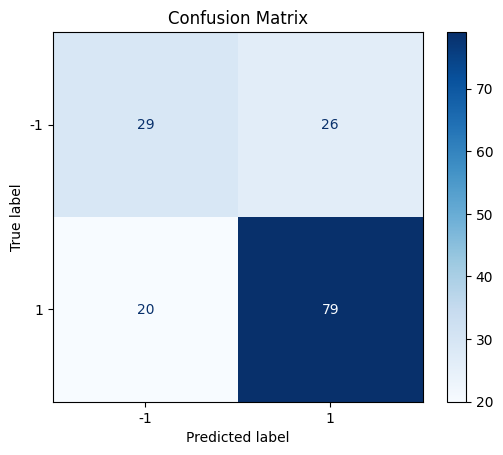

In [13]:
# Visualizing the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

AUC: 0.75


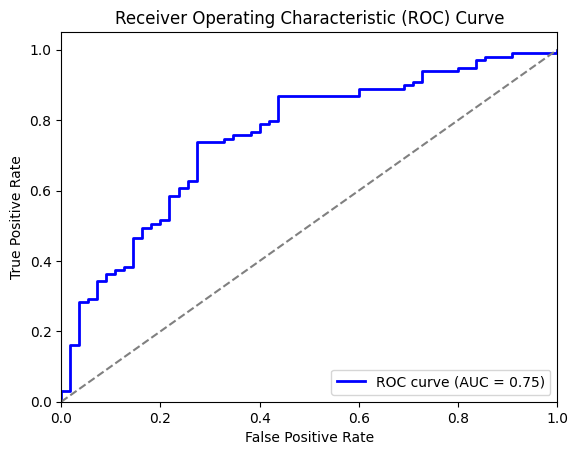

In [16]:
# ROC Curve and AUC
# Step 1: Use CalibratedClassifierCV to get probability estimates for the Perceptron
calibrated_perceptron = CalibratedClassifierCV(best_perceptron, method='sigmoid', cv=5)
calibrated_perceptron.fit(X_train, y_train)

# Step 2: Predict probabilities instead of binary labels
y_prob = calibrated_perceptron.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (1)

# Step 3: Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)

# Step 4: Calculate AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.2f}")

# Step 5: Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()